# Setup

## Imports

In [237]:
# Setup
import os


# Data Analysis
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

#Scikit learn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,auc, plot_confusion_matrix

## Configs

In [147]:
%matplotlib inline
pd.set_option('display.max_columns', None)
seed = 42

## Functions

In [172]:
def load_data(file_name, folder = "data"):
    df = pd.read_csv(os.path.join(folder, file_name))
    return df

def target_transformation(text):
    text = text.replace(" ", "").lower()
    if text == "yes" :
        return 1
    elif text == "no":
        return 0

# Data Analysis

## Data Load

In [5]:
df_original = load_data("train_data.csv","data")

In [6]:
df_original.head()

,admission_id,patient_id,race,gender,age,weight,admission_type_code,discharge_disposition_code,admission_source_code,time_in_hospital,payer_code,medical_specialty,has_prosthesis,complete_vaccination_status,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,blood_type,hemoglobin_level,blood_transfusion,max_glu_serum,A1Cresult,diuretics,insulin,change,diabetesMed,readmitted
0,0,199042938,Caucasian,Male,[50-60),?,3.0,1.0,1,1,?,?,False,Complete,24.0,3,9.0,0,0,0,721,250.6,357,5,A+,14.5,False,None,None,No,No,No,Yes,No
1,1,91962954,Caucasian,Male,[80-90),?,2.0,1.0,7,3,MC,Emergency/Trauma,False,Complete,50.0,0,8.0,0,0,1,276,507,150,9,B+,15.7,False,None,>7,No,No,No,No,Yes
2,2,109707084,EURO,Female,[60-70),?,1.0,1.0,7,5,MD,?,False,Complete,43.0,6,28.0,0,0,0,414,490,250,6,O+,13.0,False,NONE,None,No,Yes,Ch,Yes,No
3,3,157495374,Black,Female,[70-80),?,6.0,1.0,17,2,?,?,False,Complete,58.0,5,8.0,0,1,1,577,585,250,9,AB-,13.5,False,NONE,>8,No,No,No,Yes,No
4,4,82692360,Caucasian,Female,NaN,?,1.0,22.0,7,12,MC,?,False,Complete,56.0,1,16.0,0,0,2,531,532,562,8,A+,13.0,False,None,None,No,No,No,No,No


## Exploratory Data Analysis

### Overall Analysis

In [ ]:
df_original.dtypes

In [90]:
df_original['num_lab_procedures'].value_counts()

1.0      2533
43.0     2207
44.0     1988
45.0     1884
38.0     1764
         ... 
118.0       1
126.0       1
113.0       1
121.0       1
132.0       1
Name: num_lab_procedures, Length: 115, dtype: int64

In [45]:
df_original.isna().sum()

admission_id                      0
patient_id                        0
race                              0
gender                            0
age                            2336
weight                         1560
admission_type_code            1162
discharge_disposition_code      571
admission_source_code             0
time_in_hospital                  0
payer_code                        0
medical_specialty                 0
has_prosthesis                    0
complete_vaccination_status       0
num_lab_procedures             1493
num_procedures                    0
num_medications                2678
number_outpatient                 0
number_emergency                  0
number_inpatient                  0
diag_1                            0
diag_2                         1349
diag_3                            0
number_diagnoses                  0
blood_type                        0
hemoglobin_level                  0
blood_transfusion                 0
max_glu_serum               

# Pipelines

## Custom Transformers

In [7]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [137]:
class Save(BaseEstimator, TransformerMixin):
    
    def __init__(self, step):
        self.step = step
        pass
    
    def fit(self, X=None, y=None, **fit_params):
        return self
    
    def transform(self, data):
        X = data.copy()
        name = "pipeline_"+self.step+"_spy.csv"
        pd.DataFrame(X).head(50).to_csv(name)
        return X

In [178]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def pre_process_text(self, obj):
        return str(obj).replace(" ","").lower()
    
    def bool_to_binary(self, obj):
        if obj == True:
            return 1
        elif obj == False:
            return 0
    
    def text_to_binary(self, obj):
        if obj == "yes" or obj == "ch"  :
            return 1
        elif obj == "no":
            return 0
    
    def handle_missing_values(self, obj):
        if pd.isna(obj) or str(obj) == "?" or str(obj) == "unknown/invalid" or str(obj) == "nan" :
            return np.nan
        else :
            return obj
        
    def transform(self, X, y=None):
        _X = X.copy()
        for _col in _X:     
            if _col in ['has_prosthesis','blood_transfusion']:
                _X[_col] = _X[_col].apply(self.bool_to_binary)
            elif _col in ['diuretics','insulin','change','diabetesMed','readmitted']:
                _X[_col] = _X[_col].apply(self.pre_process_text)
                _X[_col] = _X[_col].apply(self.text_to_binary)
            elif _col in ['admission_source_code','discharge_disposition_code','admission_type_code','race','gender','age','weight','payer_code','medical_specialty','complete_vaccination_status','blood_type','max_glu_serum','A1Cresult','diag_1','diag_2','diag_3']:
                _X[_col] = _X[_col].apply(self.pre_process_text)
                _X[_col] = _X[_col].apply(self.handle_missing_values)
            
        return _X

In [99]:
class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self
    
    def missing_to_zero(self, obj):
        if pd.isna(obj):
            return 0
        else :
            return obj
    
    def return_float(self, obj):
        return float(obj)
    
    def return_int(self, obj):
        return int(obj)
        
    def transform(self, X, y=None):
        _X = X.copy()
        for _col in _X:
            if _col in ['num_lab_procedures','num_procedures','num_medications']:
                _X[_col] = _X[_col].apply(self.missing_to_zero)
                _X[_col] = _X[_col].apply(self.return_int)
            elif _col in ['time_in_hospital','number_outpatient','number_emergency','number_inpatient','number_diagnoses']:
                _X[_col] = _X[_col].apply(self.return_int)
            elif _col in ['hemoglobin_level']:
                _X[_col] = _X[_col].apply(self.return_float)
        return _X

In [228]:
X_train, X_test, y_train, y_test = train_test_split(df_original.drop(columns=['readmitted']), 
                                                    df_original['readmitted'],
                                                    shuffle = False,
                                                    test_size=.4, 
                                                    random_state=seed)

In [229]:
y_train = y_train.apply(target_transformation)
y_test = y_test.apply(target_transformation)

In [244]:
categorical = ['change','diabetesMed','has_prosthesis','blood_transfusion','diuretics','insulin','admission_source_code','discharge_disposition_code','admission_type_code','payer_code','complete_vaccination_status','blood_type','max_glu_serum','A1Cresult']#,'age','race','gender','weight','diag_1','diag_2','diag_3','medical_specialty']
numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses','hemoglobin_level']

cat_pipe = Pipeline([
    ('selector', ColumnSelector(categorical))
    ,('transformer',CategoricalTransformer())
    ,("save_to_csv_cat1", Save(step="cat1"))
    ,('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
    ,('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ,("save_to_csv_cat2", Save(step="cat2"))
])

num_pipe = Pipeline([
    ('selector', ColumnSelector(numerical))
    ,('transformer',NumericalTransformer())
    ,("save_to_csv_num1", Save(step="num1"))
    ,('imputer', SimpleImputer(strategy='median'))
    ,('scaler', MinMaxScaler())
    ,("save_to_csv_num2", Save(step="num2"))
])

pre_processor = FeatureUnion([
    ('cat', cat_pipe)
    ,('num', num_pipe)
])

pipe = Pipeline([
    ('preprocessor', pre_processor)
    ,('model', GradientBoostingClassifier())
])

pipe.fit(X_train, y_train)

# Predict training data
y_train_pred = pipe.predict(X_train)
print(f"Predictions on training data: {y_train_pred}")

# Predict test data
y_test_pred = pipe.predict(X_test)
print(f"Predictions on test data: {y_test_pred}")


Predictions on training data: [0 0 0 ... 0 0 0]
Predictions on test data: [0 0 0 ... 0 0 0]


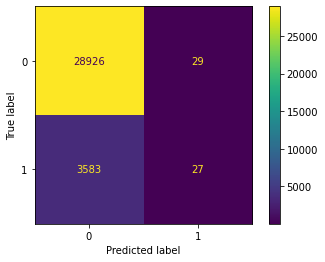

In [245]:
plot_confusion_matrix(pipe, X_test, y_test)  
plt.show()

In [280]:
for a in np.linspace(0,1,100):
    y_scores_treshold = [1 if x > a else 0 for x in y_scores]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores_treshold, pos_label=1)
    print("With treshold = {} AUC of {}".format(a,metrics.auc(fpr, tpr)))

With treshold = 0.0 AUC of 0.5
With treshold = 0.010101010101010102 AUC of 0.5000518045242618
With treshold = 0.020202020202020204 AUC of 0.5085477465031947
With treshold = 0.030303030303030304 AUC of 0.5085822828527025
With treshold = 0.04040404040404041 AUC of 0.5086168192022102
With treshold = 0.05050505050505051 AUC of 0.5136364766992052
With treshold = 0.06060606060606061 AUC of 0.5388240229489738
With treshold = 0.07070707070707072 AUC of 0.5715931589327407
With treshold = 0.08080808080808081 AUC of 0.6000021047082802
With treshold = 0.09090909090909091 AUC of 0.616089825122659
With treshold = 0.10101010101010102 AUC of 0.6218939647968407
With treshold = 0.11111111111111112 AUC of 0.625714464751159
With treshold = 0.12121212121212122 AUC of 0.6263313356143907
With treshold = 0.13131313131313133 AUC of 0.6189771739603579
With treshold = 0.14141414141414144 AUC of 0.6086071327606932
With treshold = 0.15151515151515152 AUC of 0.602197554615984
With treshold = 0.16161616161616163 AUC

ROC-AUC:


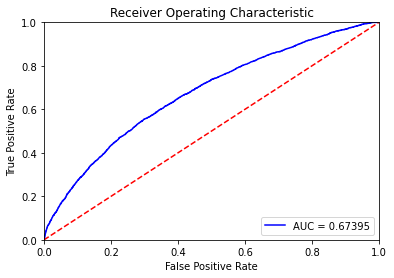

In [281]:
y_scores = pipe.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
print("ROC-AUC:")
plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()